# CelebA VGG

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import classification_report, accuracy_score

# created library
import dataaugmentation
import mydata
from skindetection import SkinExtraction
from skincolors import IndividualTypologyAngle

from mymodels import TransDataset, VGG16Model
import training

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
2024-08-12 17:10:30.273037: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 17:10:30.296729: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 17:10:30.698949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load dataset

In [2]:
db = "CelebA"
root = f"../../dataset/AAAI 2025/{db}/"
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test_with_skincolor.csv")

# Data Trainning

In [3]:
ycol="labels"
batch_size = 8
train_loader, valid_loader, test_loader = training.create_dataloaders(df_train, df_valid, df_test, ycol, batch_size)

H*W:  (218, 178)


/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Validation Accuracy: 0.8130 | Loss: 0.4254 | F1: 0.7848
Validation Accuracy: 0.8968 | Loss: 0.2556 | F1: 0.8950
Validation Accuracy: 0.9013 | Loss: 0.2368 | F1: 0.9015
Validation Accuracy: 0.8922 | Loss: 0.2629 | F1: 0.8979
Validation Accuracy: 0.8986 | Loss: 0.2395 | F1: 0.8979
Validation Accuracy: 0.8889 | Loss: 0.2945 | F1: 0.8952
Validation Accuracy: 0.8983 | Loss: 0.2423 | F1: 0.8920
Validation Accuracy: 0.8913 | Loss: 0.3130 | F1: 0.8979
Validation Accuracy: 0.9062 | Loss: 0.2434 | F1: 0.9018
Validation Accuracy: 0.8989 | Loss: 0.3159 | F1: 0.8909
Validation Accuracy: 0.9147 | Loss: 0.2197 | F1: 0.9105
Validation Accuracy: 0.9129 | Loss: 0.2153 | F1: 0.9100
Validation Accuracy: 0.9159 | Loss: 0.2258 | F1: 0.9141
Validation Accuracy: 0.9068 | Loss: 0.2613 | F1: 0.9016
Validation Accuracy: 0.9053 | Loss: 0.2420 | F1: 0.9020
Validation Accuracy: 0.8764 | Loss: 0.4951 | F1: 0.8603
Validation Accuracy: 0.9117 | Loss: 0.2628 | F1: 0.9133
Validation Accuracy: 0.9171 | Loss: 0.2326 | F1:

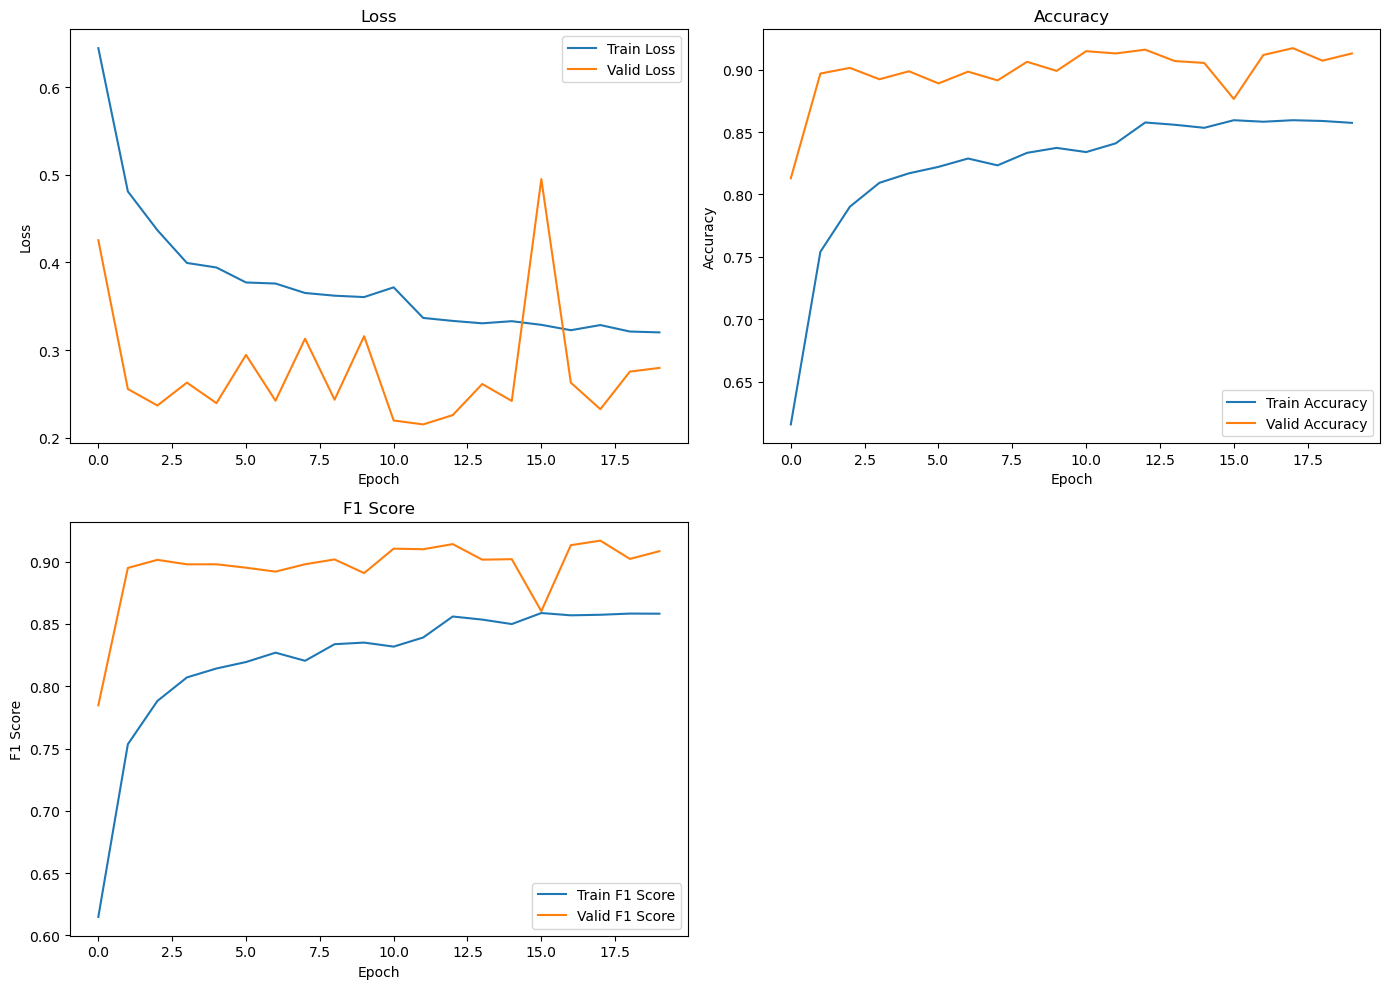

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_directory = f"{root}/model/vgg/"
model = VGG16Model().to(device) # model -> GPU

# Train the model
num_epochs = 20
lr = 0.00001
best_val_file = training.train_model(model, train_loader, valid_loader, model_save_directory, num_epochs=num_epochs, lr=lr)

# Evaluation

In [5]:
model = VGG16Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))

model.eval() # 評価モードに入る。dropoutは学習にしか使わない。dropoutはノイズを入れている。ノイズに耐えられるように。
with torch.no_grad():
    test_predictions = []
    test_outputs = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
        outputs = model(inputs)
        # _, test_predictions = torch.max(outputs, 1) # outputsの大きい方が選ばれるけど、二値分類なので異なる
        test_outputs.append(outputs)
        test_predictions.extend(1 if x >= 0.5 else 0 for x in outputs) # Appendは１つ、extendは複数

df_test["predictions"] = test_predictions

/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [6]:
training.test_classification_report(df_test)
df_test.to_csv(f"../../dataset/AAAI 2025/{db}/evaluation/df_test_vgg.csv", index=False)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2107
           1       0.95      0.86      0.90      2169

    accuracy                           0.91      4276
   macro avg       0.91      0.91      0.91      4276
weighted avg       0.91      0.91      0.91      4276

Skin tone 2: Accuracy 0.8979118329466357
Skin tone 1: Accuracy 0.9165487977369166


In [7]:
df_train["mean ita"] = means
df_train["distance"] = distances

NameError: name 'means' is not defined